In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

from tensorflow import keras
%matplotlib inline

### Parameters for plotting model results ###
pd.set_option("display.max_colwidth",100)
sns.set(style="ticks", color_codes=True)
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

def test_data(train_df, test_df, model, test_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(test_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df_copy = test_df.copy()
    df_copy.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df_copy
    
def train_data(train_df, model, train_seq, obs_col, output_col='pred'):
    '''Predict mean ribosome load using model and test set UTRs'''
    
    # Scale the test set mean ribosome load
    scaler = preprocessing.StandardScaler()
    scaler.fit(train_df[obs_col].values.reshape(-1,1))
    
    # Make predictions
    predictions = model.predict(train_seq).reshape(-1,1)
    
    # Inverse scaled predicted mean ribosome load and return in a column labeled 'pred'
    df_copy = train_df.copy()
    df_copy.loc[:,output_col] = scaler.inverse_transform(predictions)
    return df_copy

def r2(x,y):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return r_value**2

In [3]:
# train = pd.read_csv('../data/egfp_unmod_1_split/train.csv')
# valid = pd.read_csv('../data/egfp_unmod_1_split/valid.csv')
# train_one_hot = np.load('../data/egfp_unmod_1_split/onehot_train.npy')
# valid_one_hot = np.load('../data/egfp_unmod_1_split/onehot_valid.npy')
# train_structure = np.load('../data/egfp_unmod_1_split/structure_train.npy')
# valid_structure = np.load('../data/egfp_unmod_1_split/structure_valid.npy')

train = pd.read_csv('../data/egfp_unmod_1_split/train_no_uAUG.csv')
valid = pd.read_csv('../data/egfp_unmod_1_split/valid_no_uAUG.csv')
train_one_hot = np.load('../data/egfp_unmod_1_split/onehot_train_no_uAUG.npy')
valid_one_hot = np.load('../data/egfp_unmod_1_split/onehot_valid_no_uAUG.npy')
train_structure = np.load('../data/egfp_unmod_1_split/structure_train_no_uAUG.npy')
valid_structure = np.load('../data/egfp_unmod_1_split/structure_valid_no_uAUG.npy')

train_structure = np.expand_dims(train_structure, axis=3)
valid_structure = np.expand_dims(valid_structure, axis=3)

In [5]:
model = keras.models.load_model('weights.05-0.65')

In [6]:
valid = test_data(train_df=train, test_df=valid, model=model, obs_col='rl',test_seq=[valid_one_hot, valid_structure])
r = r2(valid['rl'], valid['pred'])
print('r-squared = ', r)

r-squared =  0.375065967622408


In [9]:
# atg = valid[valid['utr'].apply(lambda x: 'ATG' in x)]
n_atg = valid[valid['utr'].apply(lambda x: 'ATG' not in x)]

In [10]:
# print("uATG: ", r2(atg['rl'], atg['pred']))
print("no uATG: ", r2(n_atg['rl'], n_atg['pred']))

no uATG:  0.375065967622408


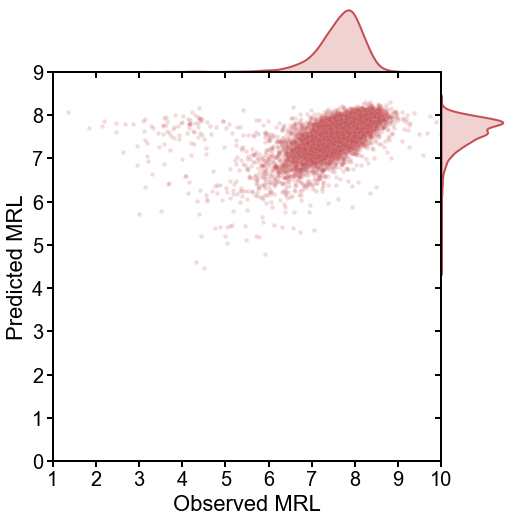

In [11]:
c1 = (0.3, 0.45, 0.69)
c2 = 'r'
g = sns.JointGrid(x='rl', y="pred", data=atg, space=0, xlim=(1,10), ylim=(0,10), ratio=6, height=7)
g.plot_joint(plt.scatter,s=20, color=c1, linewidth=0.2, alpha=0.1, edgecolor='white')
f = g.fig
ax = f.gca()
ax.set_yticks(np.arange(0,9.01, 1))
ax.set_yticklabels(range(10),size=20)
ax.set_xticks(np.arange(1,10.01, 1))
ax.set_xticklabels(range(1,11),size=20)
ax.set_ylim(0,9)
ax.set_xlim(1,10)
g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22})

g.x = n_atg['rl'].values
g.y = n_atg['pred'].values
g.plot_joint(plt.scatter, s=20, linewidth=0.2, alpha=0.2, color=c2, edgecolor='white')
g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
f = g.fig

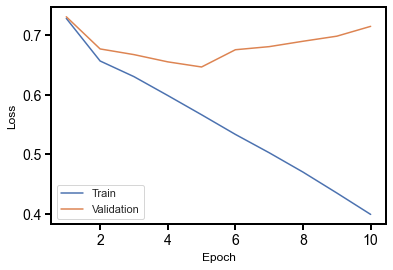

In [12]:
with open('history.txt', 'r') as f:
  lines = f.readlines()
  train_loss = list(map(float, lines[0][1:-2].split(", ")))
  val_loss = list(map(float, lines[1][1:-2].split(", ")))

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss)
plt.plot(epochs, val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Train", "Validation"])
plt.show()